In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
import warnings; warnings.simplefilter('ignore')
from scipy.stats import uniform,loguniform
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import os

In [2]:
#definition of the two models

#burst model

def model_1(t_data,par):
    A=par[0]
    B=par[1]
    t_0=par[2]
    a=par[3]
    if t_data < t_0:
        y=B
    if t_data >= t_0:
        y=B+A*np.exp(-a*(t_data-t_0))
    return y

#gaussian model

def model_2(t_data,par):
    A=par[0]
    B=par[1]
    t_0=par[2]
    w=par[3]
    y=B+A*np.exp(-0.5*((t_data-t_0)/w)**2)
    return y

#definition of the likelihood for both models

def log_likelihood(par,t_data,y_data,err_data,model):
    if model=='model_1':
        log_likelihoods=np.array([(-(y_data[i]-model_1(t_data[i],par))**2/(2*err_data[i]**2)) for i in range(0,len(t_data))])
    if model=='model_2':
            log_likelihoods=np.array([(-(y_data[i]-model_2(t_data[i],par))**2/(2*err_data[i]**2)) for i in range(0,len(t_data))])

    return np.sum(log_likelihoods)

#definition of the prior starting from a point of a unity hypercube

def ptform(u,model):
    x=np.array(u)
    x[0]=uniform(loc=0,scale=50).ppf(u[0])
    x[1]=uniform(loc=0,scale=50).ppf(u[1])
    x[2]=uniform(loc=0,scale=100).ppf(u[2])
    if model=='model_1':
        x[3]=loguniform.ppf(u[3],np.exp(-5),np.exp(5))
    if model=='model_2':
        x[3]=uniform(loc=1,scale=10).ppf(u[3])
    return x


<ErrorbarContainer object of 3 artists>

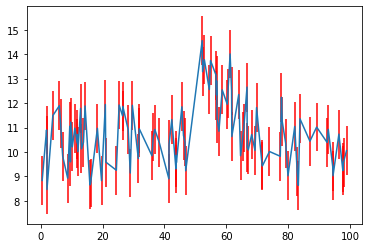

In [3]:
#loading data

data=np.load('transient.npy')
t_data=data[:,0]
y_data=data[:,1]
err_data=data[:,2]

#plotting

plt.errorbar(data[:,0],data[:,1],data[:,2],ecolor='red')

1701it [04:18,  6.58it/s, +100 | bound: 369 | nc: 1 | ncall: 66646 | eff(%):  2.706 | loglstar:   -inf < -48.772 <    inf | logz: -63.434 +/-  0.364 | dlogz:  0.001 >  0.109]


Bayesian evidence for model 1 is: 2.824017214827029e-28


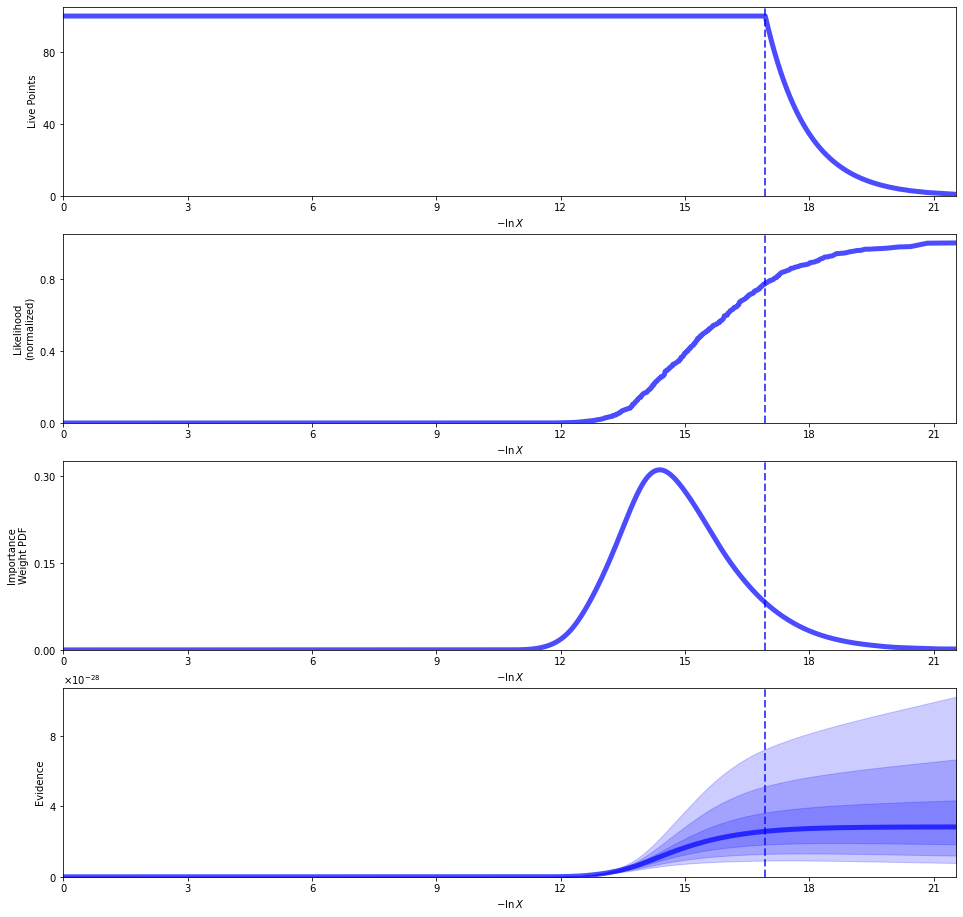

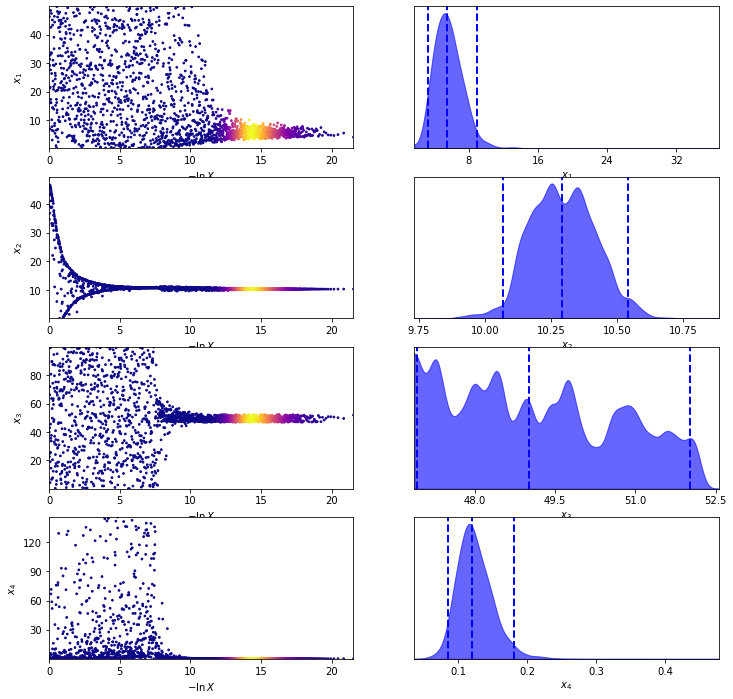

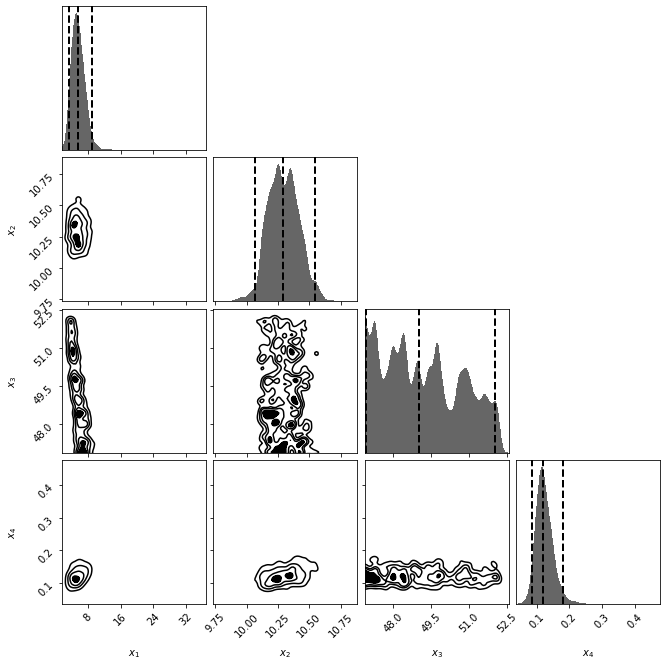

In [4]:
#defining the dimensionality 

ndim=4

#preparing and running the sampler

sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim,logl_args=[t_data,y_data,err_data,'model_1'],ptform_args=['model_1'],nlive=100)
sampler.run_nested()

#reading the results and plotting

sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,,labels=['A','B','t0','a'])
cfig, caxes = dyplot.cornerplot(sresults,,labels=['A','B','t0','a'])
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

#computing the means and covariance matrix of the parameters

mean1, cov1 = dyfunc.mean_and_cov(samples,weights)

#computing the evidence

model1_evidence= sresults.logz[-1]
print("Bayesian evidence for model 1 is:", np.exp(model1_evidence))

#since the cell takes a while this line reproduce a soundalert when using a mac. 
#if you are not using a mac please comment the following line.

os.system('afplay /System/Library/Sounds/Blow.aiff')

1738it [02:52, 10.10it/s, +100 | bound: 186 | nc: 1 | ncall: 35154 | eff(%):  5.243 | loglstar:   -inf < -52.448 <    inf | logz: -67.490 +/-  0.364 | dlogz:  0.001 >  0.109]


Bayesian evidence for model 2 is: 4.89248880689061e-30


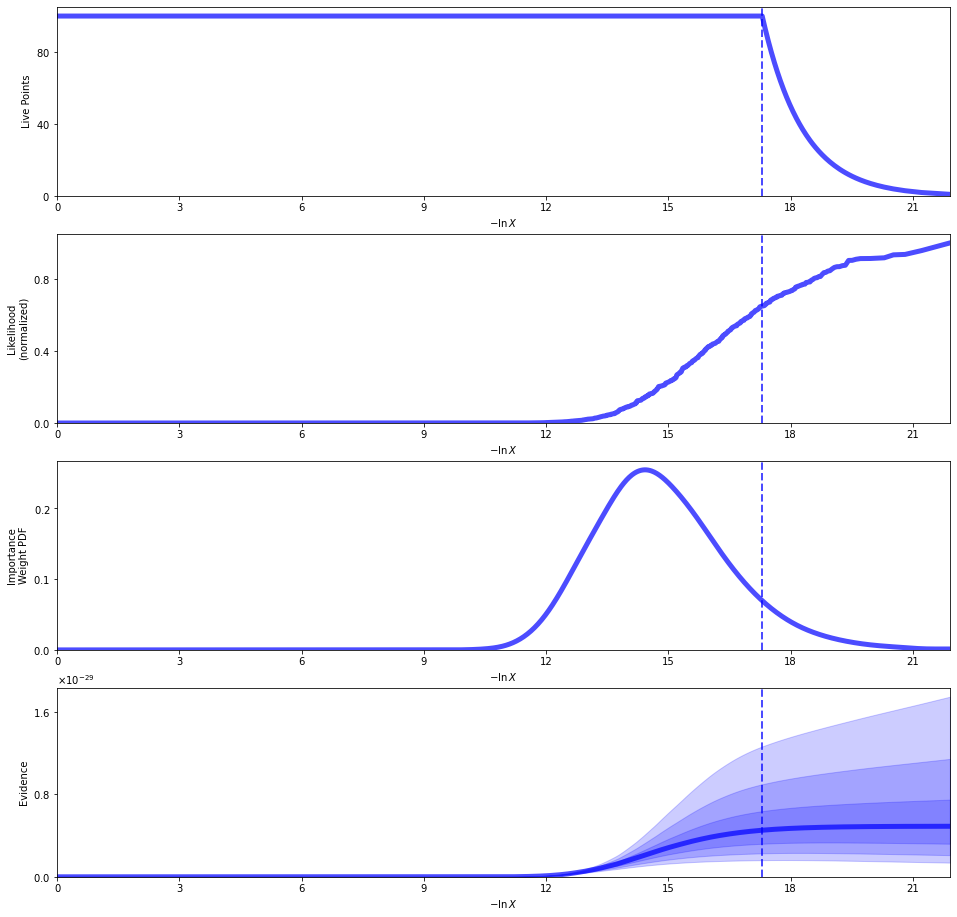

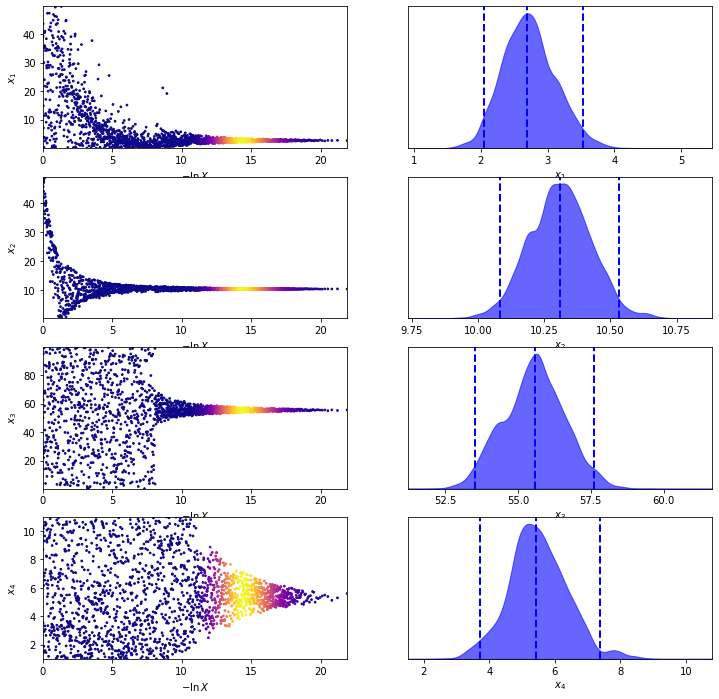

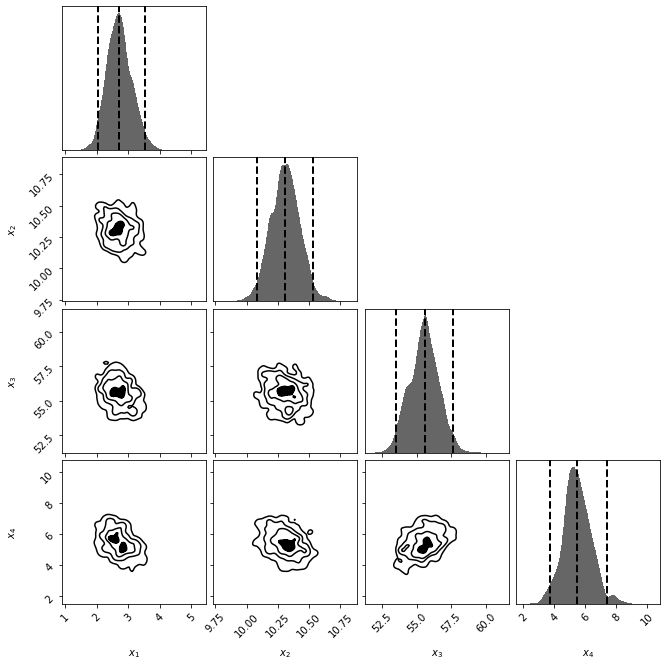

In [5]:
#defining the dimensionality 

ndim=4

#preparing and running the sampler

sampler = dynesty.NestedSampler(log_likelihood, ptform, ndim,logl_args=[t_data,y_data,err_data,'model_2'],ptform_args=['model_2'],nlive=100)
sampler.run_nested()

#reading the results and plotting

sresults = sampler.results
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults,labels=['A','B','t0',r'$\sigma_W$'])
cfig, caxes = dyplot.cornerplot(sresults,labels=['A','B','t0',r'$\sigma_W$'])
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

#computing the means and covariance matrix of the parameters

mean2, cov2 = dyfunc.mean_and_cov(samples,weights)

#computing the evidence

model2_evidence= sresults.logz[-1]
print("Bayesian evidence for model 2 is:", np.exp(model2_evidence))

#since the cell takes a while this line reproduce a soundalert when using a mac. 
#if you are not using a mac please comment the following line.

os.system('afplay /System/Library/Sounds/Blow.aiff')

In [8]:
#comparing the two models 
evidence_ratio=np.exp(model1_evidence-model2_evidence)
print(evidence_ratio)
if(evidence_ratio<1):
    print('model 2 is preferred')
if(evidence_ratio>1 and evidence_ratio<3):
    print('model 1 is preferred')
if(evidence_ratio>3 and evidence_ratio<10):
    print('model 1 is preferred with a substantial evidence')
if(evidence_ratio>10 and evidence_ratio<30):
    print('model 1 is preferred with a strong evidence')
if(evidence_ratio>30 and evidence_ratio<100):
    print('model 1 is preferred with a very strong evidence')
if(evidence_ratio>100):
    print('model 1 is preferred with a decisive evidence')

57.72148545030223
model 1 is preferred with a very strong evidence


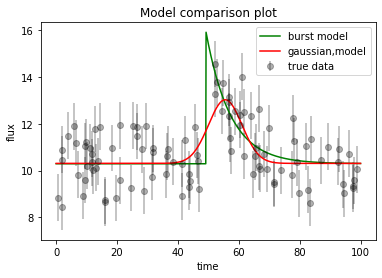

In [36]:
#preparing the grid and computing the two models

xgrid=np.linspace(0,100,1000)
y1=np.array([model_1(x,mean1) for x in xgrid])
y2=np.array([model_2(x,mean2) for x in xgrid])

#plotting

plt.plot(xgrid,y1,color='green',label='burst model')
plt.plot(xgrid,y2,color='red',label='gaussian,model')
plt.errorbar(data[:,0],data[:,1],data[:,2],color='black',fmt="o",ecolor='black',alpha=0.3,label='true data')

plt.legend()

plt.xlabel('time')
plt.ylabel('flux')
plt.title('Model comparison plot')
plt.show()